In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob


In [13]:
def plot_image(img, title=None, size=(12,6)):
    plt.figure(figsize=size)
    plt.axis("off")
    
    if title is not None:
        plt.title(title)
        
    if len(img.shape) == 3:
        plt_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(plt_image)
    else:
        plt.imshow(img, cmap='gray')        

    plt.show() 

In [14]:
# define the calibration pattern
nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

cali_files = glob.glob('./camera_cal/calibration*.jpg')

for fname in cali_files:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)

    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)

        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (7,6), corners2,ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

In [17]:
def undistort_image(img):
    global mtx, dist
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


plot_example_image = False
if plot_example_image:
    img = cv2.imread('./camera_cal/calibration1.jpg')
    img_undist = undistort_image(img)

    plot_image(img)
    plot_image(img_undist)


In [5]:
def mouse_callback(event, x, y, flags, param):    
    # begin drawing the distorted rectangle on the image in the lower left corner and move on in clockwise direction   
    
    img, img_orig, window_name, mouse_x, mouse_y = param
    
    if event == cv2.EVENT_LBUTTONUP:        
        mouse_x.append(x)
        mouse_y.append(y)  
        
    color = (0,0,255)
    thickness = 1
    
    if len(mouse_x) < 4:
        img = np.copy(img_orig)
        
    if len(mouse_x) == 1:         
        cv2.line(img, (mouse_x[0],mouse_y[0]), (x, y), color=color, thickness=thickness) 
    elif len(mouse_x) == 2:        
        cv2.line(img, (mouse_x[0],mouse_y[0]), (mouse_x[1],mouse_y[1]), color=color, thickness=thickness)
        cv2.line(img, (mouse_x[1],mouse_y[1]), (x, y), color=color, thickness=thickness)         
    elif len(mouse_x) == 3:
        cv2.line(img, (mouse_x[0],mouse_y[0]), (mouse_x[1],mouse_y[1]), color=color, thickness=thickness)
        cv2.line(img, (mouse_x[1],mouse_y[1]), (mouse_x[2],mouse_y[2]), color=color, thickness=thickness)
        cv2.line(img, (mouse_x[2],mouse_y[2]), (x, y), color=color, thickness=thickness) 
        cv2.line(img, (mouse_x[0],mouse_y[0]), (x, y), color=color, thickness=thickness)        

    cv2.imshow(window_name, img)
    

def get_warped_rectangle():    
    
    global mouseX, mouseY
    mouse_x = []
    mouse_y = []   
    
    img_orig = cv2.imread('./test_images/straight_lines1.jpg')
    img = np.copy(img_orig)
    
    window_name = 'perspective transform'
    cv2.namedWindow(window_name)
    cv2.setMouseCallback(window_name, mouse_callback, (img, img_orig, window_name, mouse_x, mouse_y))
    cv2.imshow(window_name, img)

    while len(mouse_x) < 4 and cv2.getWindowProperty(window_name, 0) >= 0:    
        k = cv2.waitKey(20) & 0xFF

    cv2.destroyWindow(window_name)   
        
    return mouse_x, mouse_y    


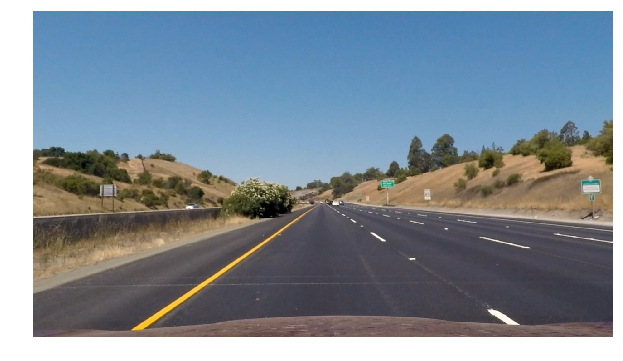

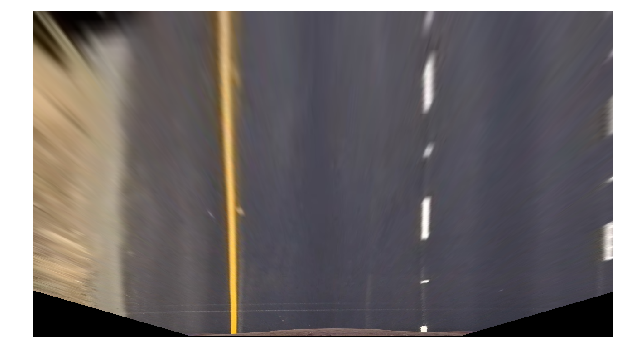

In [19]:
def calculate_warp_matrices(get_user_rectangle=False):
    
    global M, M_inv    
    
    if get_user_rectangle:
        # let the user choose a new warped rectangle
        px, py = get_warped_rectangle()    
    else:
        # use previously determined points that work well 
        px = [300, 600, 684, 1006]
        py = [664, 452, 452, 664]   
    
    src = np.zeros((4,2), dtype='float32') 
    for i in range(4):   
        src[i, 0] = px[i] 
        src[i, 1] = py[i]           
    
    x_min = np.min(px)
    y_min = np.min(py)
    x_max = np.max(px)
    y_max = np.max(py)    
    
    x_offset = 150    
    y_max_factor = 1.05
    y_min_factor = -0.2
    
    dst = np.float32([[x_min+x_offset, y_max_factor*y_max], 
                      [x_min+x_offset, y_min_factor*y_min], 
                      [x_max-x_offset, y_min_factor*y_min], 
                      [x_max-x_offset, y_max_factor*y_max]])                                 
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)

    
calculate_warp_matrices(get_user_rectangle=False)

plot_example_image = True
if plot_example_image:
    img = cv2.imread('./test_images/straight_lines1.jpg')
    img_undist = undistort_image(img)

    plot_image(img_undist)
    plot_image(warp_image(img_undist))

In [7]:
def warp_image(img):
    global M
    return cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))

def unwarp_image(img):
    global M_inv
    return cv2.warpPerspective(img, M_inv, (img.shape[1], img.shape[0]))


In [8]:
from sklearn.linear_model import RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

#def crop_image(img):    
#    return img[:,:img.shape[1]-100]

def low_pass_filter(new_value, old_value, filter_coeff):
    return filter_coeff*old_value + (1.0 - filter_coeff)*new_value

def fit_polynomial(img, line, is_left_lane_line=False, ransac=True, plot=False):    
    
    nonzero = img.nonzero()
   
    x_data = np.array(nonzero[0])
    y_data = np.array(nonzero[1])    
    
    x_m_per_pix = 6/100 # meters per pixel in x dimension (= y-dimension in original image)
    y_m_per_pix = 3.7/430 # meters per pixel in y dimension (= x-dimension in original image)   
    
    x_data = x_data*x_m_per_pix
    y_data = y_data*y_m_per_pix   
        
    if ransac:    
        estimator = RANSACRegressor(random_state=42, residual_threshold=20)

        model = make_pipeline(PolynomialFeatures(2), estimator)
        
        model.fit(x_data.reshape(-1, 1), y_data.reshape(-1, 1))         
 
        A = estimator.estimator_.coef_[0][2]
        B = estimator.estimator_.coef_[0][1]
        C = estimator.estimator_.intercept_[0]
        
        #poly_y = model.predict(poly_x.reshape(-1, 1))[:,0] # alternative method
    else:         
        poly_fit = np.polyfit(x_data, y_data, 2) 
        
        A = poly_fit[0]
        B = poly_fit[1]
        C = poly_fit[2]      
    
    if line.poly_coeff is None:
        line.poly_coeff = []
        line.poly_coeff.append(A)
        line.poly_coeff.append(B)
        line.poly_coeff.append(C)

        
    line.poly_coeff[0] = A
    line.poly_coeff[1] = B
    line.poly_coeff[2] = C       
        
    poly_x = np.linspace(0, img.shape[0]-1, 100)*x_m_per_pix  
    poly_y = A*poly_x**2 + B*poly_x + C    
    
    # evaluate curvature at the current vehicle position    
    x_eval = np.max(poly_x) 
    curvature = ((1 + (2*A*x_eval + B)**2)**1.5) / np.absolute(2*A) 
    
    if line.curvature is None:        
        line.curvature = curvature
    else: 
        line.curvature = low_pass_filter(curvature, line.curvature, 0.9)


    # calculate vehicle offset from middle of the lane
    if is_left_lane_line: # left lane line    
        lateral_offset = 0.5*img.shape[1]*y_m_per_pix - poly_y[-1]
    else:
        lateral_offset = poly_y[-1] - 0.5*img.shape[1]*y_m_per_pix
        
    if line.lateral_offset is None:        
        line.lateral_offset = lateral_offset
    else: 
        line.lateral_offset = low_pass_filter(lateral_offset, line.lateral_offset, 0.9)
        
        
    # transform back to pixel coordinates
    poly_x = poly_x/x_m_per_pix
    poly_y = poly_y/y_m_per_pix      
    
    global debug_mode
    if debug_mode:        
        plt.imshow(img, cmap='gray')     
        plt.plot(poly_y, poly_x)
        plt.axis('equal')
        plt.show() 
    
    return poly_y, poly_x


In [9]:
def threshold_image(img, thresh_min, thresh_max):    
    res = np.zeros_like(img)
    res[(img >= thresh_min) & (img <= thresh_max)] = 1
    return res

def draw_lane_on_image(img_orig, x_left, y_left, x_right, y_right, curvature, offset):    
    # Create an image to draw the lines on   
    color_warp = np.zeros_like(img_orig).astype(np.uint8)    

    # Recast the x and y points into usable format for cv2.fillPoly()
    ind_max = int(0.98*len(x_right))
    pts_left = np.array([np.transpose(np.vstack([x_left[:ind_max], y_left[:ind_max]]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([x_right[:ind_max], y_right[:ind_max]])))])
    pts = np.hstack((pts_left, pts_right))
    pts_middle = np.array([np.transpose(np.vstack([x_left + 0.5*(x_right-x_left), y_left]))])

    # Draw the lane onto the blank image
    cv2.fillPoly(color_warp, np.int32(pts), (0, 255, 0))
    #cv2.polylines(color_warp, np.int32(pts_left), False, (0, 255, 0), thickness=5) #left lane line 
    #cv2.polylines(color_warp, np.int32(pts_right), False, (0, 255, 0), thickness=5) #right lane line 
    #cv2.polylines(color_warp, np.int32(pts_middle), False, (250, 100, 0), thickness=30) #middle of lane 

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    new_warp = cv2.warpPerspective(color_warp, M_inv, (img_orig.shape[1], img_orig.shape[0])) 
    
    if curvature > 9999:
        curv_string = 'straight lane'
    else:
        curv_string = 'radius of curvature={}'.format(int(curvature))
    
    cv2.putText(new_warp, curv_string, (500, 50), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 3, cv2.LINE_AA)
    cv2.putText(new_warp, 'offset={0:.2f}'.format(float(offset)), (500, 100), 
                cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), 3, cv2.LINE_AA)
    
    # Combine the result with the original image
    result = cv2.addWeighted(img_orig, 1, new_warp, 0.3, 0)
    
    return result

def get_scaled_abs_sobel_image(img_gray, direction):    
    sobel_kernel_size = 11
    sobel_img = cv2.Sobel(img_gray, cv2.CV_64F, direction[0], direction[1], ksize=sobel_kernel_size)    
    
    abs_sobel_img = np.absolute(sobel_img)    
    scaled_abs_sobel = np.uint8(255*abs_sobel_img/np.max(abs_sobel_img))     
    return scaled_abs_sobel

def get_initial_mask(img_gray, start_x, end_x):
    mask = np.zeros_like(img_gray)
    size_x = img_gray.shape[1]
    mask[:, int(start_x*size_x):int(end_x*size_x)] = 1
    return mask

class Line():
    def __init__(self):
        self.curvature = None
        self.lateral_offset = None       
        self.poly_coeff = None # [A, B, C]        
        self.mask = None # binary mask image 


In [12]:
def create_line_binary_images(img_orig, left_line, right_line):
    
    img_undist = undistort_image(img_orig)
    img_warped = warp_image(img_undist)
    img_gray = cv2.cvtColor(img_warped, cv2.COLOR_BGR2GRAY)  
    
    if left_line.mask is None:
        left_line.mask = get_initial_mask(img_gray, 0.25, 0.4)  
        right_line.mask = get_initial_mask(img_gray, 0.6, 0.75)  

    # filter the grayscale image with sobel edge detection  
    scaled_sobel_x = get_scaled_abs_sobel_image(img_gray, [1, 0])
    scaled_sobel_y = get_scaled_abs_sobel_image(img_gray, [0, 1])    

    sobelx_binary = threshold_image(scaled_sobel_x, 30, 255)
    sobely_binary = threshold_image(scaled_sobel_y, 40, 255)
    
    sobel_binary = sobelx_binary & ~sobely_binary      
   
    # extract S channel of hte image in HLS color space     
    hls = cv2.cvtColor(img_warped, cv2.COLOR_BGR2HLS)    
    s_channel = hls[:,:,2]
    s_channel_binary = threshold_image(s_channel, 80, 255) # 100, 255
    
    red_channel = img_warped[:,:,2] # red channel is the last channel in BGR format    
    red_channel_binary = threshold_image(red_channel, 130, 255)
    
    # combine R and S channel binary images
    s_red_binary = s_channel_binary & red_channel_binary    
   
    # combine binary images of color channels and sobel edge detection 
    img_binary = sobel_binary | s_red_binary
    
    # clean the image from small isolated spots via the morphological 'opening' operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))
    img_binary = cv2.morphologyEx(img_binary, cv2.MORPH_OPEN, kernel)  
    
    # mask the binary image with the lane line masks of the previous frame    
    img_binary_left = img_binary & left_line.mask     
    img_binary_right = img_binary & right_line.mask 
    
    global debug_mode
    if debug_mode:
        plot_image(img_gray, title='img_gray')
        
        # sobel
        #plot_image(scaled_sobel_x, title='scaled_sobel_x')
        #plot_image(scaled_sobel_y, title='scaled_sobel_y')
        plot_image(sobel_binary, title='sobel_binary')
        
        # S and R channels
        #plot_image(s_channel, title='s_channel')
        plot_image(s_channel_binary, title='s_channel_binary')
        #plot_image(red_channel_binary, title='red_channel_binary')
        
        #plot_image(img_binary, title='img_binary cleaned') 
        plot_image(left_line.mask , 'left_line.mask')
        plot_image(right_line.mask , 'right_line.mask')
    
    return img_binary_left, img_binary_right



In [ ]:
def detect_lines(img_orig, left_line, right_line):
    
    # warp, mask and perform filtering operations on the image
    img_binary_left, img_binary_right = create_line_binary_images(img_orig, left_line, right_line)    
    
    # fit a polynomial to the white lane lines pixels
    x_left, y_left   = fit_polynomial(img_binary_left, left_line, is_left_lane_line=True)
    x_right, y_right = fit_polynomial(img_binary_right, right_line, is_left_lane_line=False)
     
    curvature = 0.5*(left_line.curvature + right_line.curvature)    

    offset_correction = 0.3
    lateral_offset = 0.5*((left_line.lateral_offset - 0.5*3.7) + (0.5*3.7 - right_line.lateral_offset)) + offset_correction
    
    #offset_from_middle = 0.5*((offset_left - 0.5*3.7) + (0.5*3.7 - offset_right)) + offset_correction
    #offset_from_middle = low_pass_filter(offset_from_middle, offset_from_middle_old, 0.7)    
    
    result_image = draw_lane_on_image(img_orig, 
                                      x_left, y_left, x_right, y_right, 
                                      curvature, lateral_offset)
    
    # create line masks for next frame
    pts_left = np.array([np.transpose(np.vstack([x_left, y_left]))])
    pts_right = np.array([np.transpose(np.vstack([x_right, y_right]))])
    
    left_line.mask[:,:] = 0
    right_line.mask[:,:] = 0
    
    left_line.mask = cv2.polylines(left_line.mask, np.int32(pts_left), False, (1, 1, 1), thickness=80)
    right_line.mask = cv2.polylines(right_line.mask, np.int32(pts_right), False, (1, 1, 1), thickness=80) 

    return result_image

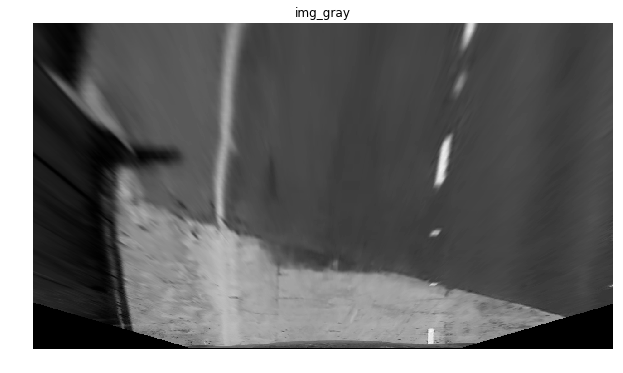

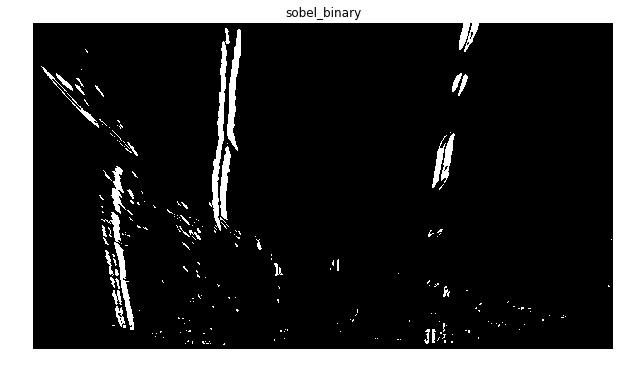

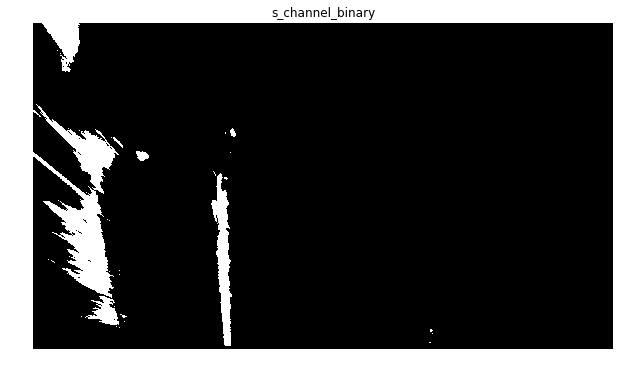

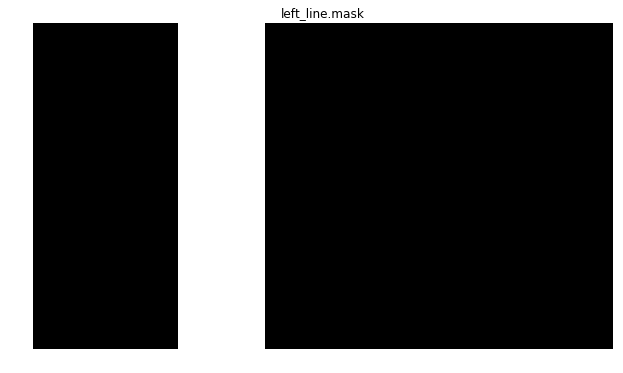

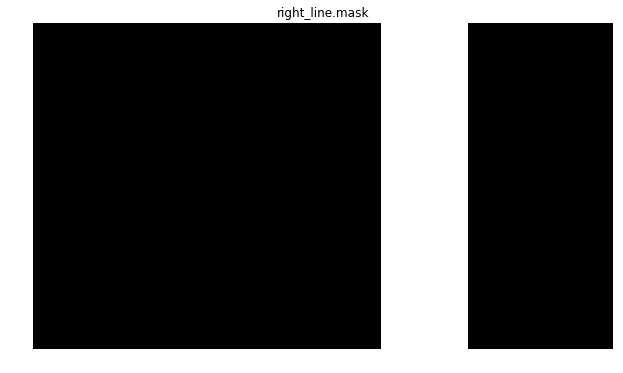

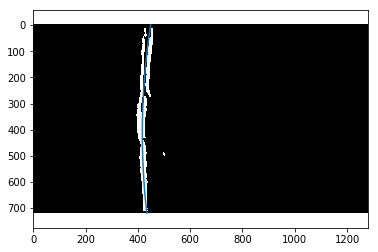

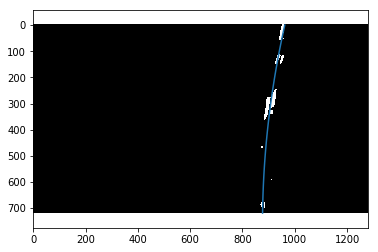

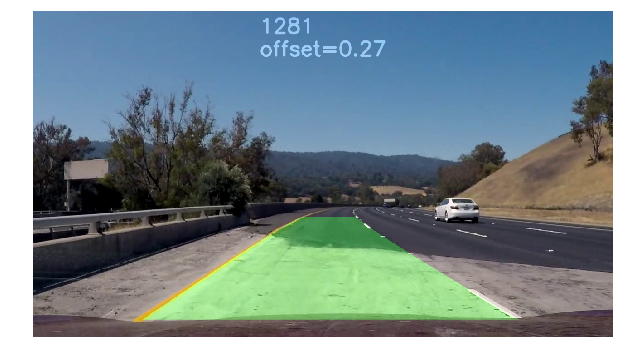

In [11]:
#img = cv2.imread('./test_images/straight_lines1.jpg')
#img = cv2.imread('./test_images/test5.jpg')
#plot_image(img, title='original image')

debug_mode = True

img = cv2.imread('./bad_image1.jpg')

left_line = Line()
right_line = Line()
res = detect_lines(img, left_line, right_line)

plot_image(res)

In [ ]:
vidcap = cv2.VideoCapture('project_video.mp4')
#vidcap = cv2.VideoCapture('challenge_video.mp4')
success,image = vidcap.read()
count = 1
success = True

success, img = vidcap.read()

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('output.avi',fourcc, 24.0, (img.shape[1],img.shape[0]))

debug_mode = False

left_line = Line()
right_line = Line()
mask = None

success, img = vidcap.read()
while success:    
    
    count += 1  
    
    if count > 0:# and count < 650:
        res = detect_lines(img, left_line, right_line)   
        video.write(res)
        
    #print(count)
    if count % 100 == 0:
        pass
        #break
        print(count)
        
        #cv2.imwrite('bad_image3.jpg', img)
        
    success, img = vidcap.read()
    
video.release() 
